In [154]:
import pandas as pd
from get_data_from_athena import fetch_athena_query_as_dataframe
import matplotlib.pyplot as plt

In [155]:
# get tables from Athena
sellout_raw = fetch_athena_query_as_dataframe('get_sellout_timeseries')
sellout_derived = fetch_athena_query_as_dataframe('get_sellout_derived')
sellout_timeseries = fetch_athena_query_as_dataframe('get_sellout_timeseries')

✅ S3 파일 삭제 완료: athena-results/1fd63435-4e0b-4811-9408-291f1cd03e3f.csv
✅ [get_sellout_timeseries.sql] Athena 데이터 로딩 완료
✅ S3 파일 삭제 완료: athena-results/4c8a8ab7-244c-43d5-8700-13db67b66ae4.csv
✅ [get_sellout_derived.sql] Athena 데이터 로딩 완료
✅ S3 파일 삭제 완료: athena-results/e24711fd-cc26-4506-976d-538934546749.csv
✅ [get_sellout_timeseries.sql] Athena 데이터 로딩 완료


In [165]:
# 첫 번째 병합 (겹치는 컬럼엔 _dup1 붙이기)
merged_df_1 = pd.merge(
    sellout_raw,
    sellout_derived,
    on=["sku", "store_id", "customer_id", "forecast_dt"],
    how="left",
    suffixes=("", "_dup1")
)

# 두 번째 병합 (겹치는 컬럼엔 _dup2 붙이기)
merged_df_2 = pd.merge(
    merged_df_1,
    sellout_timeseries,
    on=["sku", "store_id", "customer_id", "forecast_dt"],
    how="left",
    suffixes=("", "_dup2")
)


merged_df_2["sellout"] = merged_df_2["sellout"].astype(float)
merged_df_2["sellout_raw"] = merged_df_2["sellout_raw"].astype(float)
merged_df_2["forecast_dt"] = pd.to_datetime(merged_df_2["forecast_dt"])

merged_df_2 = merged_df_2.sort_values("forecast_dt")

merged_df_2 = merged_df_2[merged_df_2['forecast_dt']<'2025-02-01']


merged_df_2["sellout_raw"] = merged_df_2["sellout_raw"].interpolate(method="linear")
merged_df_2["sellout"] = merged_df_2["sellout"].interpolate(method="linear")


# 중복된 컬럼 제거
merged_df_2 = merged_df_2[[col for col in merged_df_2.columns if not col.endswith("_dup1") and not col.endswith("_dup2")]]






In [166]:
merged_df_3 = merged_df_2[merged_df_2['sku']=='SC40TR03']

In [167]:
merged_df_3["sellout"] = merged_df_3["sellout"].astype(float)
merged_df_3["sellout_raw"] = merged_df_3["sellout_raw"].astype(float)
merged_df_3["forecast_dt"] = pd.to_datetime(merged_df_3["forecast_dt"])

merged_df_3 = merged_df_3.sort_values("forecast_dt")

merged_df_3 = merged_df_3[merged_df_3['forecast_dt']<'2025-02-01']

/var/folders/mk/cmf6f9tx60519t_1_l_8ystc0000gn/T/ipykernel_37793/889360395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_3["sellout"] = merged_df_3["sellout"].astype(float)
/var/folders/mk/cmf6f9tx60519t_1_l_8ystc0000gn/T/ipykernel_37793/889360395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_3["sellout_raw"] = merged_df_3["sellout_raw"].astype(float)
/var/folders/mk/cmf6f9tx60519t_1_l_8ystc0000gn/T/ipykernel_37793/889360395.py:3: SettingWithCopyWarning: 
A value is trying to

In [168]:
merged_df_3[merged_df_3['sellout_raw']==0]

,sku,store_id,customer_id,forecast_dt,promotion_target_day,promotion_day_type,discount_rate,sellout,sellout_raw


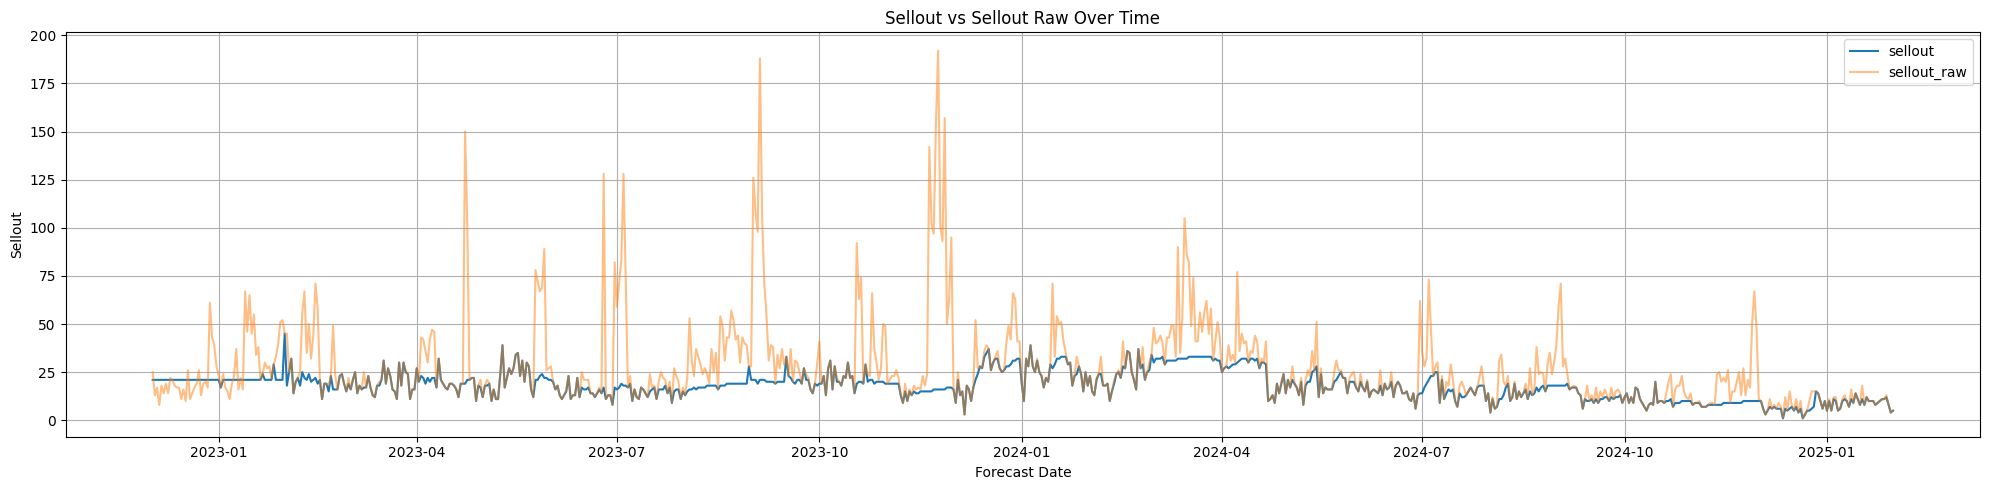

In [169]:
plt.figure(figsize=(20, 5))

plt.plot(merged_df_3["forecast_dt"], merged_df_3["sellout"], label="sellout")
plt.plot(merged_df_3["forecast_dt"], merged_df_3["sellout_raw"], label="sellout_raw", alpha=0.5)

plt.xlabel("Forecast Date")
plt.ylabel("Sellout")
plt.title("Sellout vs Sellout Raw Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [170]:
merged_df_3[merged_df_3.isna().any(axis=1)]


,sku,store_id,customer_id,forecast_dt,promotion_target_day,promotion_day_type,discount_rate,sellout,sellout_raw


In [171]:
merged_df_3["sellout_raw"] = merged_df_3["sellout_raw"].interpolate(method="linear")
merged_df_3["sellout"] = merged_df_3["sellout"].interpolate(method="linear")


In [172]:
merged_df_3.isna().sum()

sku                     0
store_id                0
customer_id             0
forecast_dt             0
promotion_target_day    0
promotion_day_type      0
discount_rate           0
sellout                 0
sellout_raw             0
dtype: int64

In [173]:

# data pre-processing ------


# Extract components
merged_df_2['year'] = merged_df_2['forecast_dt'].dt.year
merged_df_2['month'] = merged_df_2['forecast_dt'].dt.month
merged_df_2['week'] = merged_df_2['forecast_dt'].dt.isocalendar().week
merged_df_2['day'] = merged_df_2['forecast_dt'].dt.day
merged_df_2['weekday'] = merged_df_2['forecast_dt'].dt.weekday  # e.g., Monday

# merged_df_2 = merged_df_2.drop(columns=['forecast_dt'])
# --------------------------

# save final dataset
print("Data pre-processing done")
print(f"shape: {merged_df_2.shape}")
print(f"columns: {merged_df_2.columns}")
merged_df_2.to_csv("/Users/joel/Documents/github/MLOps_test/data_temp_storage/final_data.csv", index=False)

Data pre-processing done
shape: (2374, 14)
columns: Index(['sku', 'store_id', 'customer_id', 'forecast_dt', 'promotion_target_day',
       'promotion_day_type', 'discount_rate', 'sellout', 'sellout_raw', 'year',
       'month', 'week', 'day', 'weekday'],
      dtype='object')
